In [1]:
#hide
from fastbook import *
setup_book()

# ResNets

## Going Back to Imagenette

In [2]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [3]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

Two more approaches to solving the problem of final output size than tiered stride-2
- flatten the final layer from 3-d to a 1-d vector as FC layer
- Take average of activations

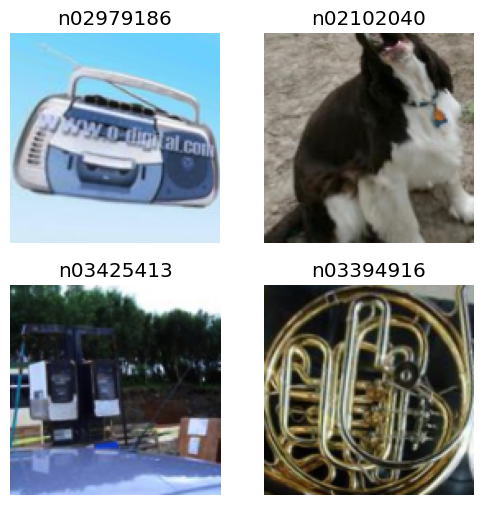

In [4]:
dls.show_batch(max_n=4)

In [5]:
def avg_pool(x): return x.mean((2,3))

In [6]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [7]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

SuggestedLRs(valley=0.0004786300996784121)

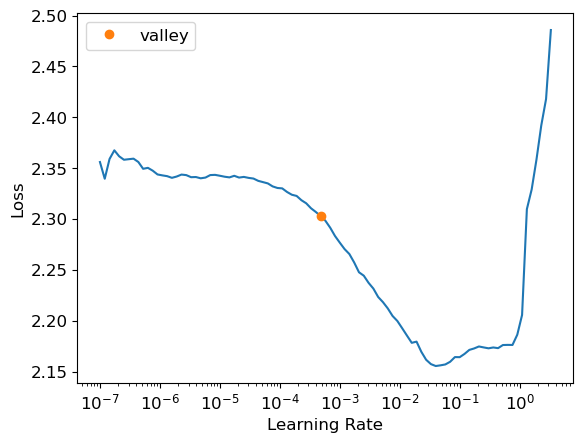

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.884062,2.184635,0.340127,00:11
1,1.529840,1.637298,0.481274,00:11
2,1.280680,1.154650,0.639745,00:11
3,1.122297,1.067402,0.664713,00:10
4,1.034998,1.070050,0.660382,00:10


## Building a Modern CNN: ResNet

### Skip Connections

The iddea is to sum the outputs of e.g. 2 layers back with the current layer's activations

In [10]:
class ResBlock(Module):
    def __init__(self, ni, nf):
        self.convs = nn.Sequential(
            ConvLayer(ni,nf),
            ConvLayer(nf,nf, norm_type=NormType.BatchZero))
        
    def forward(self, x): return x + self.convs(x)

In [11]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

In [12]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [13]:
def block(ni,nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())

In [14]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.956899,1.819134,0.379363,00:11
1,1.667872,1.533013,0.495032,00:11
2,1.369273,1.385745,0.547516,00:11
3,1.150228,1.066022,0.661911,00:11
4,1.011704,1.038890,0.676178,00:11


In [15]:
def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))

In [16]:
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.955583,1.852984,0.359236,00:11
1,1.624193,1.766340,0.429045,00:11
2,1.329295,1.204785,0.600764,00:11
3,1.105682,1.012841,0.676178,00:11
4,0.967140,0.942904,0.696051,00:11


### A State-of-the-Art ResNet

In [17]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [18]:
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [19]:
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

In [20]:
rn = ResNet(dls.c, [2,2,2,2])

In [21]:
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.646255,3.557862,0.268790,00:11
1,1.316647,1.363097,0.566624,00:11
2,1.075994,1.022821,0.661401,00:11
3,0.899035,0.841907,0.734522,00:11
4,0.763120,0.767130,0.759745,00:11


### Bottleneck Layers

In [22]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

In [23]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

In [24]:
rn = ResNet(dls.c, [3,4,6,3], 4)

In [25]:
learn = get_learner(rn)
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.592663,1.647958,0.480000,00:27
1,1.348668,2.139128,0.409682,00:27
2,1.236427,2.246269,0.379108,00:27
3,1.145174,1.669984,0.481783,00:26
4,1.063254,1.854257,0.505223,00:27
5,0.988161,1.125732,0.663694,00:27
6,0.859519,1.253034,0.632866,00:27
7,0.761938,1.021485,0.707771,00:27
8,0.697308,0.903674,0.728917,00:27
9,0.663270,1.262722,0.626242,00:27


## Conclusion

## Questionnaire

1. How did we get to a single vector of activations in the CNNs used for MNIST in previous chapters? Why isn't that suitable for Imagenette?
1. What do we do for Imagenette instead?
1. What is "adaptive pooling"?
1. What is "average pooling"?
1. Why do we need `Flatten` after an adaptive average pooling layer?
1. What is a "skip connection"?
1. Why do skip connections allow us to train deeper models?
1. What does <<resnet_depth>> show? How did that lead to the idea of skip connections?
1. What is "identity mapping"?
1. What is the basic equation for a ResNet block (ignoring batchnorm and ReLU layers)?
1. What do ResNets have to do with residuals?
1. How do we deal with the skip connection when there is a stride-2 convolution? How about when the number of filters changes?
1. How can we express a 1×1 convolution in terms of a vector dot product?
1. Create a `1x1 convolution` with `F.conv2d` or `nn.Conv2d` and apply it to an image. What happens to the `shape` of the image?
1. What does the `noop` function return?
1. Explain what is shown in <<resnet_surface>>.
1. When is top-5 accuracy a better metric than top-1 accuracy?
1. What is the "stem" of a CNN?
1. Why do we use plain convolutions in the CNN stem, instead of ResNet blocks?
1. How does a bottleneck block differ from a plain ResNet block?
1. Why is a bottleneck block faster?
1. How do fully convolutional nets (and nets with adaptive pooling in general) allow for progressive resizing?

### Further Research

1. Try creating a fully convolutional net with adaptive average pooling for MNIST (note that you'll need fewer stride-2 layers). How does it compare to a network without such a pooling layer?
1. In <<chapter_foundations>> we introduce *Einstein summation notation*. Skip ahead to see how this works, and then write an implementation of the 1×1 convolution operation using `torch.einsum`. Compare it to the same operation using `torch.conv2d`.
1. Write a "top-5 accuracy" function using plain PyTorch or plain Python.
1. Train a model on Imagenette for more epochs, with and without label smoothing. Take a look at the Imagenette leaderboards and see how close you can get to the best results shown. Read the linked pages describing the leading approaches.